# Intellijoint Advanced Researcher - Technical Assessment
## Authored by: Samuel Newhook

### Requirements
Jupyter Notebook is required to run this file. Installation guide [here](https://jupyter.org/install).
All packages required will need to be installed if not already. One debugging note is that if the package stl is already installed there may be some issues with from stl import mesh. If this happens, uninstall stl and numpy-stl and then reinstall numpy-stl as recommended [here](https://stackoverflow.com/questions/29661823/importing-of-3d-stl-image-in-python-importerror-no-module-named-ascii).

### Introduction
This project is a naive x-ray simulation. It is based on the idea that a simplified x-ray emitter can be modelled as a point source and a detector. By projecting rays along lines that run from the emitter to the vertices of the detector, we can detect any objects in the path of the rays by attenuating the signal when the ray and the object intersect. To do this, we sample evenly along the lines to form intermediate slices. We then sample evenly inside the slices for points which intersect the volume of any object which we have loaded.

### External Libraries
External Libraries include some standard python libraries such as numpy, os and matplotlib. The library numpy-stl is used for dealing with stl files. A link to documentation can be found [here](https://pypi.org/project/numpy-stl/). A link to the winding algorithm for determining points in a polygon can be found [here](http://geomalgorithms.com/a03-_inclusion.html).

In [4]:
import numpy
from numpy import linalg as LA
import os
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot
%matplotlib notebook

In [5]:
class Plane:
    # Plane of form ax + by + cz = d
    def __init__(self, pts):
        self._a, self._b, self._c, self._d = self._plane_from_points(pts)
        abs_abc = numpy.absolute([self._a, self._b, self._c])
        self._max_ind_norm = numpy.where(abs_abc == numpy.max(abs_abc))[0]
        
    def _plane_from_points(self, pts:numpy.array):
        v1 = pts[2, :] - pts[0, :]
        v2 = pts[1, :] - pts[0, :]
        cp = numpy.cross(v1, v2)
        a, b, c = cp
        d = numpy.dot(cp, pts[2, :])
        return a, b, c, d
    
    def intersection_pt(self, line):
        plane_abc = numpy.array([self._a, self._b, self._c])
        denom = numpy.dot(plane_abc, line.slope)
        if denom == 0:
            return numpy.array([numpy.nan, numpy.nan, numpy.nan]), numpy.nan
        s = (self._d - numpy.dot(plane_abc, line.initial_pt)) / denom
        return line.get_point_on_line(s), s
    
    def get_y_given_xz(self, x, z):
        y = (self._d - self._a * x - self._c * z) / self._b
        return y
    
    @property
    def largest_index_in_norm(self):
        return self._max_ind_norm
        
    @property
    def a(self):
        return self._a
    
    @property
    def b(self):
        return self._b
    
    @property
    def c(self):
        return self._c
    
    @property
    def d(self):
        return self._d
    
    @property
    def is_vertical(self):
        return self._b == 0
    
class LineSegment:
    def __init__(self, pts):
        self._slope, self._initial_pt, self._final_pt = self._line_from_pts(pts)
        self._segment_length = LA.norm(self._final_pt - self._initial_pt)
        
    def _line_from_pts(self, pts):
        xs = pts[1, 0] - pts[0, 0]
        ys = pts[1, 1] - pts[0, 1]
        zs = pts[1, 2] - pts[0, 2]
        slope = numpy.array([xs, ys, zs])
        norm_slope = slope / LA.norm(slope)
        xi = pts[0, 0]
        yi = pts[0, 1]
        zi = pts[0, 2]
        return norm_slope, numpy.array([xi, yi, zi]), numpy.array([pts[1, 0], pts[1, 1], pts[1, 2]])
    
    def get_point_on_line(self, s):
        return self._slope * s + self._initial_pt
    
    def vec_along_slope(self, s):
        return self._slope * s
    
    @property
    def slope(self):
        return self._slope
    
    @property
    def initial_pt(self):
        return self._initial_pt
    
    @property
    def final_pt(self):
        return self._final_pt
    
    @property
    def segment_length(self):
        return self._segment_length

#The following three functions are used to determine if a point is inside a polygon
def is_left(p0, p1, p2):
    # tests if a point is Left|On|Right of an infinite line.
    # Input:  three points P0, P1, and P2
    # Return: >0 for P2 left of the line through P0 and P1
    # =0 for P2  on the line
    # <0 for P2  right of the line
    return ((p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1]))

def proj_2d(p_gon, pt):
    # Make 2d simply by discarding an axis
    plane = Plane(p_gon)
    discard_ind = plane.largest_index_in_norm[0]
    return numpy.delete(p_gon, discard_ind, 1), numpy.delete(pt, discard_ind)

def is_point_in_polygon(p_gon, test_point) -> bool:
    p_gon_2d, pt_2d = proj_2d(p_gon, test_point)
    wn = 0
    for edge_ind in range(0, p_gon_2d.shape[0]):
        vertex_i = p_gon_2d[edge_ind]
        vertex_i_plus_1 = p_gon_2d[edge_ind + 1] if edge_ind + 1 != p_gon_2d.shape[0] else p_gon_2d[0]
        if vertex_i[1] <= pt_2d[1]:
            if vertex_i_plus_1[1] > pt_2d[1]:
                if is_left(vertex_i, vertex_i_plus_1, pt_2d) > 0:
                    wn += 1
        else:
            if vertex_i_plus_1[1] <= pt_2d[1]:
                if is_left(vertex_i, vertex_i_plus_1, pt_2d) < 0:
                    wn -= 1
    return wn != 0

<IPython.core.display.Javascript object>


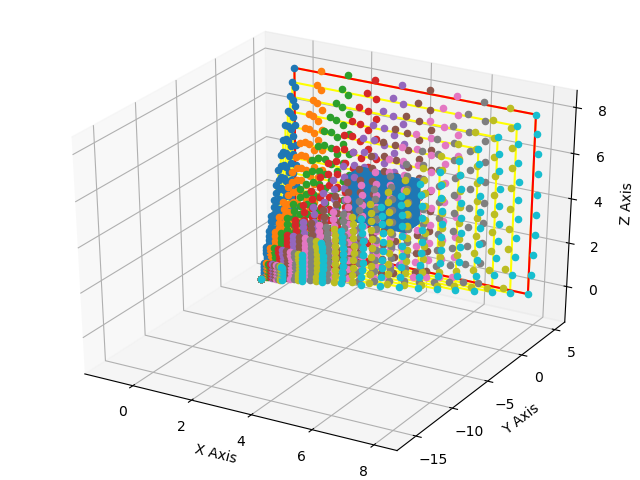

E:\anaconda\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  # This is added back by InteractiveShellApp.init_path()


<IPython.core.display.Javascript object>


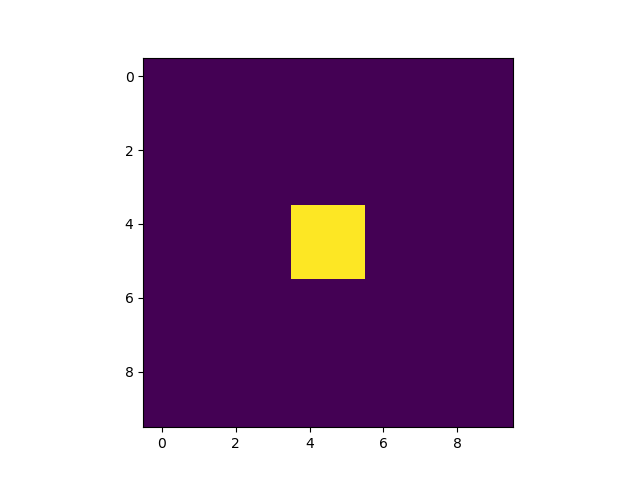

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [25]:
sample_mesh = mesh.Mesh.from_file('cube.stl')
screen_offset = 4
screen_size = 8
center_pos = screen_size / 2
pt_offset = -16
t_form = numpy.array([[1, 0, 0, 4], [0, 1, 0, 0], [0, 0, 1, 4], [0, 0, 0, 1]])
sample_mesh.transform(t_form)
figure = pyplot.figure()
axes = mplot3d.Axes3D(figure)
axes.add_collection3d(mplot3d.art3d.Poly3DCollection(sample_mesh.vectors))
scale = sample_mesh.points.flatten(-1)
axes.auto_scale_xyz(scale, scale, scale)
emitter_pt = numpy.array([center_pos, pt_offset, center_pos])
axes.scatter(emitter_pt[0], emitter_pt[1], emitter_pt[2], color='green')
screen = numpy.array([[0, screen_offset, 0], [screen_size, screen_offset, 0], [screen_size, screen_offset, screen_size], [0, screen_offset, screen_size]])
num_pixels_w = 10
num_pixels_l = 10
num_slices = 15

limits_of_integration = [LineSegment(numpy.array([emitter_pt, scr_pt])) for scr_pt in screen]

line_segment_of_integration = [LineSegment(
    numpy.vstack((limits_of_integration[0].final_pt, limits_of_integration[1].final_pt))),
                              LineSegment(
    numpy.vstack((limits_of_integration[0].final_pt, limits_of_integration[3].final_pt)))]

linspace_s_0 = numpy.linspace(0, line_segment_of_integration[0].segment_length, num_pixels_w)
linspace_s_1 = numpy.linspace(0, line_segment_of_integration[1].segment_length, num_pixels_l)

all_lines = numpy.array([[LineSegment(
    numpy.vstack(
        (
            emitter_pt, 
            limits_of_integration[0].get_point_on_line(
                limits_of_integration[0].segment_length) + line_segment_of_integration[0].vec_along_slope(
                s_0) + line_segment_of_integration[1].vec_along_slope(
                s_1)))) for s_0 in linspace_s_0] for s_1 in linspace_s_1])


max_seg_length = numpy.max(numpy.array([loi.segment_length for loi in all_lines.reshape(all_lines.size)]))

s_at_verts = numpy.linspace(0, max_seg_length, num_slices)

pixels = numpy.zeros((num_pixels_w, num_pixels_l))

for line_idx, segment_s in enumerate(s_at_verts):
    p_1 = limits_of_integration[0].get_point_on_line(segment_s)
    p_2 = limits_of_integration[1].get_point_on_line(segment_s)
    p_3 = limits_of_integration[2].get_point_on_line(segment_s)
    p_4 = limits_of_integration[3].get_point_on_line(segment_s)
    points_ = numpy.array([p_1, p_2, p_3, p_4, p_1])
    axes.plot(points_[:, 0], points_[:, 1], points_[:, 2] , color='yellow')

    for x_idx, test_line_row in enumerate(all_lines):
        for z_idx, test_line in enumerate(test_line_row):
            s_list = []
            face_intersect_count = 0
            test_pt = test_line.get_point_on_line(segment_s)
            axes.scatter(test_pt[0], test_pt[1], test_pt[2])
            test_pt_vert = test_pt + numpy.array([0, 1, 0])
            for vec in sample_mesh.vectors:
                plane = Plane(vec)
                test_line = LineSegment(numpy.array([test_pt, test_pt_vert]))
                intersect, s = plane.intersection_pt(test_line)
                is_in_pgon = is_point_in_polygon(vec, intersect) if not numpy.isnan(s) else False
                if is_in_pgon and not s in s_list and s >= 0:
                    face_intersect_count += 1
                    s_list.append(s)
            attenuate = face_intersect_count % 2 != 0
            if attenuate:
                pixels[x_idx, z_idx] += 1
axes.plot([0, screen_size, screen_size, 0, 0], [screen_offset, screen_offset, screen_offset, screen_offset, screen_offset], [0, 0, screen_size, screen_size, 0], color='red')
axes.set_xlabel('X Axis')
axes.set_ylabel('Y Axis')
axes.set_zlabel('Z Axis')
pyplot.figure()
pyplot.imshow(pixels.reshape((num_pixels_w, num_pixels_l)))
print(pixels)
pyplot.show()